# Introduction

Suite à la publication de 340 notices d'entités LRM par le groupe Systèmes et Données https://zenodo.org/record/7358799 voici un ensemble de scripts pour visualiser un peu leur contenu

Les données diffusées en iso2709 ont été converties en MarcXML pour faciliter les traitements.

**Plan**
 * [Objectifs](#Objectifs)


 1. **[Construction des données](#1.-Construction-des-donn%C3%A9es)**
   * [Chargement des données initiales](#Chargement-des-donn%C3%A9es-initiales)
     * [Fonctions d'extraction](#Fonctions-d'extraction)
       * [Zones de liens entre entités OEMI](#Zones-de-liens-entre-entit%C3%A9s-OEMI)
       * [Classes et fonctions](#Classes-et-fonctions)
   * [Initialisation des entités](#Initialisation-des-entit%C3%A9s)
   * [Les dictionnaires utiles](#Les-dictionnaires-utiles)
     * [Dictionnaire ID > entité complète](#Dictionnaire-ID-%3E-entit%C3%A9-compl%C3%A8te)
     * [Dictionnaire Manif > Item](#Dictionnaire-Manif-%3E-Items)
     * [Propriétés Oeuvre.toExpressions, Oeuvre.toManifs, Oeuvre.toItems](#Propri%C3%A9t%C3%A9s-Oeuvre.toExpressions,-Oeuvre.toManifs,-Oeuvre.toItems)
     * [Propriétés Expression.toManifs, Expression.toItems](#Propri%C3%A9t%C3%A9s-Expression.toManifs,-Expression.toItems)
     * [Propriétés Manif.toItems, Manif.toOeuvres](#Propri%C3%A9t%C3%A9s-Manif.toOeuvre,-Manif.toItems)
     * [Propriétés Item.toOeuvres, Item.toExpressions](#Propri%C3%A9t%C3%A9s-Item.toOeuvres,-Item.toExpressions)


 2. **[Les entités](#2.-Les-entit%C3%A9s)**
   * [Les oeuvres](#Les-oeuvres)     
     * [Propriété oeuvre.detailed](#Propri%C3%A9t%C3%A9-oeuvre.detailed)
     * [Propriétés de liens aux autres entités : oeuvre.toExpressions, oeuvre.toManifs, oeuvre.toItems](#Propri%C3%A9t%C3%A9s-de-liens-aux-autres-entit%C3%A9s-:-oeuvre.toExpressions,-oeuvre.toManifs,-oeuvre.toItems)
     * [Propriétés oeuvre.resp, oeuvre.respIds](#Propri%C3%A9t%C3%A9s-oeuvre.resp,-oeuvre.respIds)
     * [Liste des titres des oeuvres](#Liste-des-titres-des-oeuvres)
     * [Analyse d'une oeuvre précise](#Analyse-d'une-oeuvre-pr%C3%A9cise)
       * [Expressions et manifestations liées](#Expressions-et-manifestations-li%C3%A9es)
       * [Autres liens](#Autres-liens)
   * [Les expressions](#Les-expressions)
     * [Liste des expressions et liens aux oeuvres](#Liste-des-expressions-et-liens-aux-oeuvres)
   * [Les manifestations](#Les-manifestations)
     * [Liens dans les manifs](#Liens-dans-les-manifestations)
     * [Liste des manifs et liens aux expressions](#Liste-des-manifs-et-liens-aux-expressions)
   * [Les items](#Les-items)
   

 3. **[Relations entre entités](#Relations-entre-entit%C3%A9s)**
   * [Codes fonctions](#Codes-fonctions)
   * [Liens dans les manifs](#Liens-dans-les-manifs)


 4. **[Visualisation en graphe](#3.-Visualisation-en-graphe)**
   * [Générer un graphe Gephi](#G%C3%A9n%C3%A9rer-un-graphe-Gephi)
   * [Avec GraphViz](#Avec-GraphViz)


 * [Coquilles rencontrées](#Coquilles-rencontrées)

In [1]:
# Déclaration des librairies et variables globales

import SRUextraction as sru # import du fichier https://github.com/Lully/bnf-sru/blob/master/SRUextraction.py
from lxml import etree
from string import ascii_lowercase
import re
from collections import defaultdict
import pandas as pd
from pprint import pprint
from IPython.display import FileLink, FileLinks

from unidecode import unidecode

ns = {"marc": "http://www.loc.gov/MARC21/slim"}

# Objectifs

* **Contrôler les données et faire remonter d'éventuels problèmes dans leur contenu ou leur architecture**


* **Fournir des outils pour manipuler les données**, savoir ce qu'elles contiennent. Cela passe par construire un "objet" (Python) intermédiaire pour chaque entité, doté de plusieurs attributs, à savoir :
  * un point d'accès et/ou un label
  * le contenu intégral de la notice
  * la liste des liens vers d'autres entités (avec identifiant et point d'accès)


* **proposer une visualisation pour une entité donnée** :
  * métadonnées simples
  * métadonnées enrichies des entités en liens
  * graphe de liens vers les entités OEMI et autres
  

* **proposer une visualisation pour l'ensemble des données** si cela s'avère pertinent
  
  
* **donner à voir les liens autres que les seuls arbres OEMI** : adaptations ou autres


* **Proposer une simulation d'un moteur de recherche** qui, pour un terme donné, renvoie une liste de résultats. Cela permet de réfléchir à 
  * l'affichage des résultats : quelles informations afficher ? (en imaginant un double affichage simple / détaillé)
  * l'intégration de méatdonnées des entités en lien dans le résultat affiché (pour qu'une recherche puisse s'effectuer à la fois sur des métadonnées de manifestation et d'oeuvre, par exemple)

# 1. Construction des données

## Chargement des données initiales

Nom des 4 fichiers à importer (MarcXML) import des notices en 4 arbres XML

In [2]:
manifs_filename = "UMB_Manifestations.xml"
oeuvres_expressions_filename = "UMA_Oeuvres_Expressions.xml"
autres_entites_filename = "UMA_Autres_Entites_Liees.xml"
items_filename = "UMH_Items.xml"

Import des fichiers -> conversion en arbres XML

In [3]:
manifs_file = etree.parse(manifs_filename)
oeuvres_expressions_file = etree.parse(oeuvres_expressions_filename)
autres_entites_file = etree.parse(autres_entites_filename)
items_file = etree.parse(items_filename)

### Fonctions d'extraction

#### Zones de liens entre entités OEMI

#### Classes et fonctions

Import des classes d'objet Record, Item, Manifestation, Expression et Oeuvres

Ce fichier contient aussi le dictionnaire `dic_id2type` : Numéro de notice > Type d'entité

In [4]:
from Record import *

Import d'un second fichier local avec différents dictionnaires de valeurs
1. Codes fonction (correspondance code Unimarc à 3 chiffres > Libellé). [Source : Abes](https://documentation.abes.fr/sudoc/formats/unmb/DonneesCodees/CodesFonctions.htm#TriCode)
2. Tags de liens entre entités


In [5]:
from common_dicts import * 

Le fichier Record.py définit **une classe d'objet Record** avec 4 (ou +) sous-classes:
 * Item
 * Manif
 * Expression
 * Oeuvre

Les attributs communs sont 
 * l'identifiant : **.id**
 * le type d'entité : **.type**
 * la notice en XML et en texte : **.xml** et **.txt**
 * un "label" (pas tout à fait un point d'accès en bonne et due forme) : **.label**
 * les statistiques des zones et sous-zones (dictionnaire) : **.stats_zones**
 * les liens aux mentions de responsabilités (dictionnaire) : **.resp**

Chaque entité a en plus un attribut listant (dictionnaire) la ou les entités supérieures auxquelles elle est liée : 
 * items : **.toManifs**
 * manifs : **.toExpressions**
 * expressions : **.toOeuvres**

# Initialisation des entités

On transforme les notices présentes dans les fichiers XML en objets de classes Item, Manif, Expression et Oeuvre telles que définies ci-dessus

In [6]:
manifs = [Manifestation(manif, "m") for manif in manifs_file.xpath(".//marc:record", namespaces=ns)]
oeuvres_expr = [Record(oe, "oe") for oe in oeuvres_expressions_file.xpath(".//marc:record", namespaces=ns)] 
items = [Item(oe, "i") for oe in items_file.xpath(".//marc:record", namespaces=ns)] 
autres_entites = [Record(r, "p") for r in autres_entites_file.xpath(".//marc:record", namespaces=ns)] 

oeuvres = []
expressions = []
oeuvres_or_expressions  =[]
for entity in oeuvres_expr:
    if entity.type == "o":
        oeuvre = Oeuvre(entity.xml, entity.init_type)
        oeuvres.append(oeuvre)
        
    elif entity.type == "e":
        expression = Expression(entity.xml, entity.init_type)
        expressions.append(expression)
    else:
        oeuvres_or_expressions.append(entity)

On peut donc désormais appeler manipuler les informations présentes dans ces entités : on dispose de 4 listes (items, manifs, oeuvres, expressions) 

par exemple, pour la liste des manifestations avec leur identifiant et leur label, écrire :

```for manif in manifs:
    print(manif.id, manif.label)```

Vous pouvez aussi vous demander à quoi ressemble une notice d'item en Unimarc, en affichant un des items de la liste `items`:

`print(items[0].txt)`

ou le 2e : 

`print(item[1]).txt`

**Distinction entre oeuvres et expressions dans le fichier oeuvres_expressions.xml**

Label pos.9 permet de distinguer oeuvres et expressions : valeurs h / t (auteur-titre, ou titre seul) 

Zone 154 $a pos1 : a = oeuvre ; b = expression ; x = ne s'applique pas

Point d'accès
* 231 pour les oeuvres
* 232 pour les expressions

## Les dictionnaires utiles et les attributs à enrichir

Ensemble de dictionnaires permettant de naviguer dans les entités à partir d'un élément d'information

En outre, les liens indirects (Oeuvre > Manifestation, Item > Expression) doivent être générés lors d'un second passage sur les lots d'entités, pour que chaque objet dispose de toutes ces informations comme des propriétés qui lui soient rattachées

### Dictionnaire ID > entité complète

A partir de l'identifiant (numéro de notice) on récupère l'entité de classe Item, Manif, Expression ou Oeuvre (au sens des classes définies dans le code ci-dessus

In [7]:
# dict_entities importé du fichier Record.py
for entity in items + manifs + expressions + oeuvres + autres_entites:
    dict_entities[entity.id] = entity

### Dictionnaire Manif > Items

Chaque notice contient des liens vers l'entité "supérieure" dans l'arbre FRBR. Mais les liens inverses peuvent être utiles.

On en profite pour récupérer les points d'accès des manifs dans les liens Item > Manif (au sein de l'item)

In [8]:
dict_manif2item = defaultdict(list)
for item in items:
    for manif in item.toManifs:
        try:
            manif_accesspoint = dict_entities[manif].label
        except KeyError:
            print("Manifestation", manif, f"mentionnée dans l'item {item.id} mais absente du fichier des manifestations")
        item.toManifs[manif] = manif_accesspoint
        dict_manif2item[manif].append(item.id)

### Propriétés Oeuvre.toExpressions, Oeuvre.toManifs, Oeuvre.toItems

In [9]:
for expr in expressions:
    for oeuvre in expr.toOeuvres:
        dict_entities[oeuvre].toExpressions[expr.id] = expr.label
for manif in manifs:
    for expr in manif.toExpressions:
        if expr:
            for oeuvre in dict_entities[expr].toOeuvres:
                dict_entities[oeuvre].toManifs[manif.id] = manif.label
for item in items:
    for manif in item.toManifs:
        for expr in dict_entities[manif].toExpressions:
            if expr:
                for oeuvre in dict_entities[expr].toOeuvres:
                    dict_entities[oeuvre].toItems[item.id] = item.label
# régénération de la liste des oeuvres
oeuvres = [dict_entities[o] for o in dict_entities if dict_entities[o].type == "o"]

### Propriétés Expression.toManifs, Expression.toItems

In [10]:
for manif in manifs:
    for expr in manif.toExpressions:
        if expr:
            dict_entities[expr].toManifs[manif.id] = manif.label
for expr in dict_entities:
    if dict_entities[expr].type == "e":
        for manif in dict_entities[expr].toManifs:
            items_list = dict_manif2item[manif]
            for item in items_list:
                dict_entities[expr].toItems[item] = dict_entities[item].label
# régénération de la liste des expressions
expressions = [dict_entities[e] for e in dict_entities if dict_entities[e].type == "e"]

### Propriétés Manif.toOeuvre, Manif.toItems

In [11]:
for manif in manifs:
    for expr in manif.toExpressions:
        if expr:
            oeuvres_list = dict_entities[expr].toOeuvres
            for oeuvre in oeuvres_list:
                dict_entities[manif.id].toOeuvres[oeuvre] = dict_entities[oeuvre].label
    for item in dict_manif2item[manif.id]:
        dict_entities[manif.id].toItems[item] = dict_entities[item].label
# régénération de la liste des expressions
manifs = [dict_entities[m] for m in dict_entities if dict_entities[m].type == "m"]

### Propriétés Item.toOeuvres, Item.toExpressions

In [12]:
for item in items:
    for manif in item.toManifs:
        manif_entity = dict_entities[manif]
        for expr in manif_entity.toExpressions:
            if expr:
                dict_entities[item.id].toExpressions[expr] = dict_entities[expr].label
        for oeuvre in manif_entity.toOeuvres:
            dict_entities[item.id].toOeuvres[oeuvre] = dict_entities[oeuvre].label

# 2. Les entités

## Les oeuvres

In [13]:
print("Nombre d'oeuvres : ", len(oeuvres))

Nombre d'oeuvres :  50


Exemple d'une oeuvre, avec son contenu et ses enrichissements

In [14]:
print(dict_entities["UMLRM0163"])

Drácula. film. 1931
Dates de tournage : 10/10/1930. Date de première sortie en salle : 20/03/1931 (Madrid). Date de première sortie en salle (New)

id : UMLRM0163
type initial : oe ; type : o
label : Drácula, film, 1931

Notice : 
000    01684nx  f2200349   4500
001    UMLRM0163
100    $a 20221018afrey50      ba0
101 0  $a spa
102    $a US $a ES
104    $a d1931     
125 0  $a m
127 0  $a 014400
140    $a ic $b fffa $2 BnF-GenreFilm
145 0  $a b $b xa2ae 
147 0  $a a $e b $h a 
152    $a RDA-FR
154    $a xa
231    $7 ba0yba0y $8 frespa $a Drácula $c film $d 1931 $f espagnol
370    $c Adapté de la pièce de théâtre de Hamilton Deane et John L. Balderston "Dracula"
431    $7 ba0yba0y $8 fre### $a Dracula $c film $d 1931 $m Version espagnole
441    $3 FRBNF14691107 $o ISNI 0000 0000 7844 0445 $a Melford, George (1877-1961) $t Drácula $7 ba0yba0y $8 frespa
501  1 $3 FRBNF14691107 $7 ba0yba0y $8 freeng $o ISNI 0000 0000 7844 0445 $a Melford $b George $f 1877-1961 $4 300
501  1 $7 ba0yba0y $8 f

#### Propriété oeuvre.detailed

In [15]:
print(dict_entities["UMLRM0163"].detailed)

Drácula. film. 1931
Dates de tournage : 10/10/1930. Date de première sortie en salle : 20/03/1931 (Madrid). Date de première sortie en salle (New)


#### Propriétés de liens aux autres entités : oeuvre.toExpressions, oeuvre.toManifs, oeuvre.toItems

In [16]:
print("Oeuvre.toExpressions : ", dict_entities["UMLRM0163"].toExpressions)
print("Oeuvre.toManifs      : ", dict_entities["UMLRM0163"].toManifs)
print("Oeuvre.toItems       : ", dict_entities["UMLRM0163"].toItems)

Oeuvre.toExpressions :  defaultdict(<class 'str'>, {'UMLRM0162': 'Drácula, film, 1931'})
Oeuvre.toManifs      :  defaultdict(<class 'str'>, {'UMLRM0160': 'Dracula, Tod Browning, [réalisateur], Universal StudioCanal vidéo - Universal StudioCanal vidéo, 2014 - 2014, 1 BD vidéo'})
Oeuvre.toItems       :  defaultdict(<class 'str'>, {'UMLRM1047': 'BM_CELESTEVILLE > MEZZANINE > COTE_UMLRM1047'})


#### Propriétés oeuvre.resp, oeuvre.respIds

Liens aux mentions de responsabilités

In [17]:
print("Oeuvre.resp    : ", dict_entities["UMLRM0163"].resp)
print("\n")
print("Oeuvre.respIds : ", dict_entities["UMLRM0163"].respIds)

Oeuvre.resp    :  {'Melford, George': ['Metteur en scène ou réalisateur'], 'Fernández Cué, Baltasar': ['Scénariste'], 'Villarías, Carlos': ['Acteur'], '\u200fTovar\u200f, Lupita': ['Acteur'], 'Norton, Barry': ['Acteur']}


Oeuvre.respIds :  {'', 'FRBNF14702511', 'FRBNF14691107'}


### Liste des titres des oeuvres

In [18]:
liste_titres_oeuvres = []

for oeuvre in oeuvres:
    liste_titres_oeuvres.append({"id": oeuvre.id,"Label": oeuvre.label, 
                                 "Nb Expressions liées": len(oeuvre.toExpressions),
                                 "Nb Manifs liées": len(oeuvre.toManifs),
                                 "Nb Items liés": len(oeuvre.toItems)})
liste_titres_oeuvres = pd.DataFrame(liste_titres_oeuvres)
# liste_titres_oeuvres.to_excel("Liste des oeuvres.xlsx", encoding="utf-8")
liste_titres_oeuvres

,id,Label,Nb Expressions liées,Nb Manifs liées,Nb Items liés
0,UMLRM0001,"Nosferatu, eine Symphonie des Grauens, film",1,1,1
1,UMLRM0004,"Stoker, Bram (1847-1912), Dracula",10,20,18
2,UMLRM0007,"Nosferatu, Phantom der Nacht, film",1,1,1
3,UMLRM0010,"Palma, Paola (1971-….) - Vezyroglou, Dimitri (...",1,1,1
4,UMLRM0013,"Jean-Claude Gallotta, Nosferatu, ballet de l'O...",1,1,1
5,UMLRM0031,"Stoker, Bram (1847-1912), Choix, Dracula",1,1,1
6,UMLRM0034,"Humphries, Tudor (1953-….), Dracula",2,2,1
7,UMLRM0037,"Stoker, Bram (1847-1912), Choix, Dracula",3,3,3
8,UMLRM0070,"Belford, Barbara, Bram Stoker : a biography of...",1,1,1
9,UMLRM0075,"Stoker, Bram (1847-1912), Dracula's guest",1,1,1


## Oeuvres et expressions liées

Après un peu de mise en forme du [tableau ci-contre, au format Excel](Liste%20des%20oeuvres_mef.xlsx), on voit ressortir l'oeuvre la plus reprise et éditée, avec 10 expressions et 20 manifestations liées : Dracula, de Bram Stocker


## Analyse d'une oeuvre précise

Prenons le temps de regarder cette notice d'oeuvre UMLRM0004 : Bram Stoker, Dracula, 1890

In [19]:
oeuvre_zoom = "UMLRM0004"

In [20]:
print(dict_entities[oeuvre_zoom])

Stoker, Bram (1847-1912)
Date de première publication : 1897. Date d’écriture : 08/03/1890

id : UMLRM0004
type initial : oe ; type : o
label : Stoker, Bram (1847-1912), Dracula

Notice : 
000    05455cx  h2200637   4500
001    UMLRM0004
005    20220905######.D
033    $a http://ark.bnf.fr/ark:/12148/cb12312986p $2 BnF
033    $a http://viaf.org/viaf/194144783017853134071 $2 Viaf
033    $a https://www.wikidata.org/wiki/Q41542 $2 Wikidata
033    $a https://data.bnf.fr/ark:/12148/cb12312986p $2 data.bnf.fr
035    $a 03202066X $2 SUDOC
100    $a 20220825afrey50      ba0
101 0  $a eng
102    $a GB
104    $a d1897    
125 0  $a m
140    $a te $b rofan $2 BnF-GenreLitt
140    $a te $b roepi $2 BnF-GenreLitt
145 0  $a i
152    $a RDA-FR
154    $a xa
241  1 $3 FRBNF11925586 $o ISNI 0000 0001 2122 2356 $a Stoker, Bram (1847-1912) $t Dracula $7 ba0yba0y $8 freeng
378    $a Le Dracula de Bram Stoker est une application très réussie du roman épistolaire au genre fantastique. Tout commence avec le jo

### Expressions et manifestations liées

In [21]:
for expr in dict_entities[oeuvre_zoom].toExpressions:
    print("\n", dict_entities[expr].detailed)
    for manif in dict_entities[expr].toManifs:
        print(" "*5, "|---", manif, dict_entities[manif].label)
#    print(expr, dict_entities["UMLRM0004"].toExpressions[expr])


 Stoker, Bram (1847-1912). Anglais. Dracula
Date de première publication : 1897
      |--- UMLRM0006 Dracula, Bram Stoker, Pan books -  Imprimerie Firmin-Didot, 1992, 1 volume (382 pages), couverture illustrée en couleur
      |--- UMLRM0018 Dracula, by Bram Stoker, W. Rider and son, 1992, 1 volume (VIII-404 pages)

 Stoker, Bram (1847-1912). Français. Dracula
Date de première publication : 1963
      |--- UMLRM0021 Dracula, Bram Stoker, J'ai lu - mprimerie Brodard et Taupin, 2005, 1 volume (574 pages), couverture illustrée en couleur
      |--- UMLRM0024 Dracula, Bram Stoker, Gérard et Cie, 1963, 1 volume (569 pages), couverture illustrée en couleur
      |--- UMLRM0027 Dracula, Bram Stoker, Éd. J'ai lu - mprimerie Brodard et Taupin, 1992, 1 volume (XXIV-505 pages), illustrations, couverture illustrée
      |--- UMLRM0030 Dracula, Bram Stoker, Hachette - Imprimerie Brodard et Taupin, 1988, 1 volume (534 pages), couverture illustrée en couleur
      |--- UMLRM0110 Dracula, Bram Stoker

### Autres liens

In [22]:
i = 1
for oeuvre in oeuvres:
    f541_3 = sru.record2fieldvalue(oeuvre.xml, "541$3")
    if f541_3 == oeuvre_zoom:
        lien = [sru.record2fieldvalue(oeuvre.xml, "541$p") + " " + sru.record2fieldvalue(oeuvre.xml, "541$t"), sru.record2fieldvalue(oeuvre.xml, "541$a")]
        lien = [el.strip() for el in lien if el.strip()]
        print("")
        print(i, "-", oeuvre.label, f"({oeuvre.id})")
        print(", ".join(lien))
        i += 1


1 - Nosferatu, eine Symphonie des Grauens, film (UMLRM0001)
Est une adaptation dans un autre mode de création de [œuvre] Dracula, Stoker, Bram (1847-1912)

2 -  Nosferatu, Phantom der Nacht, film (UMLRM0007)
Dracula, Stoker

3 - Stoker, Bram (1847-1912), Choix, Dracula (UMLRM0031)
Est une sélection de [œuvre] Dracula, Stoker, Bram (1847-1912)

4 - Humphries, Tudor (1953-….), Dracula (UMLRM0034)
Est une adaptation pour la jeunesse dans le même mode de création de [œuvre] Dracula, Stoker, Bram (1847-1912)

5 - Stoker, Bram (1847-1912), Choix, Dracula (UMLRM0037)
Est une sélection de [œuvre] Dracula, Stoker, Bram (1847-1912)

6 - Stoker, Bram (1847-1912), Dracula's guest (UMLRM0075)
Antépisode de Dracula, Stoker, Bram (1847-1912)

7 - Bram Stoker's Dracula, film (UMLRM0078)
Est une adaptation dans un autre mode de création de [œuvre] Dracula, Stoker, Bram (1847-1912)

8 - "Dracula" : l'oeuvre de Bram Stoker et le film de Francis F. Coppola (UMLRM0081)
Est une étude de [œuvre] Dracula, St

**Items liés**

In [23]:
for item in dict_entities["UMLRM0004"].toItems:
    print(item, dict_entities["UMLRM0004"].toItems[item])

UMLRM1001 BM_CELESTEVILLE > ADULTES > COTE_UMLRM1001
UMLRM1005 BM_CELESTEVILLE > ADULTES > COTE_UMLRM1005
UMLRM1006 BM_CELESTEVILLE > ADULTES > COTE_UMLRM1006
UMLRM1007 BM_CELESTEVILLE > ADULTES > COTE_UMLRM1007
UMLRM1008 BM_CELESTEVILLE > ADULTES > COTE_UMLRM1008
UMLRM1009 BM_CELESTEVILLE > JEUNESSE > COTE_UMLRM1009
UMLRM1013 BM_CELESTEVILLE > ADULTES > COTE_UMLRM1013
UMLRM1014 BM_CELESTEVILLE > ADULTES > COTE_UMLRM1014
UMLRM1016 BM_CELESTEVILLE > ADULTES > COTE_UMLRM1016
UMLRM1017 BM_CELESTEVILLE > JEUNESSE > COTE_UMLRM1017
UMLRM1018 BM_CELESTEVILLE > LANGUES > COTE_UMLRM1018
UMLRM1019 BM_CELESTEVILLE > MEZZANINE > COTE_UMLRM1019
UMLRM1020 BM_CELESTEVILLE > ADULTES > COTE_UMLRM1020
UMLRM1021 BM_CELESTEVILLE > LANGUES > Cote_UMLRM1021
UMLRM1022 BM_CELESTEVILLE > JEUNESSE > COTE_UMLRM1022
UMLRM1024 BM_CELESTEVILLE > ADULTES > COTE_UMLRM1024
UMLRM1035 BM_CELESTEVILLE > ADULTES > COTE_UMLRM1035
UMLRM1052 BM_CELESTEVILLE > ADULTES > COTE_UMLRM1052


## Les expressions

Les expressions sont présentes dans le fichier oeuvres_expressions, et distinguables les une des autres par la zone **154$a pos.1**, selon la valeur trouvée : 
* a : oeuvre
* b : expression
* x : autres

### Liens Expressions > mentions de responsabilités

In [24]:
stats_exp_resp = defaultdict(int)

for expr in expressions:
    stats_exp_resp[len(expr.resp)] += 1

for key in stats_exp_resp:
    print("Nombre d'expressions contenant", key, "mentions de responsabilités : ", stats_exp_resp[key])

Nombre d'expressions contenant 1 mentions de responsabilités :  12
Nombre d'expressions contenant 0 mentions de responsabilités :  34
Nombre d'expressions contenant 2 mentions de responsabilités :  5
Nombre d'expressions contenant 4 mentions de responsabilités :  1
Nombre d'expressions contenant 10 mentions de responsabilités :  1


### Fichier contenant les expressions

In [25]:
def line2report(line, file):
    file.write(line)
    file.write("\n")

with open("expressions.txt", "w", encoding="utf-8") as f:
    for expr in expressions:
        line2report("\n"*2, f)
        line2report(f"{expr.id} : {expr.label}", f)
        line2report(expr.txt, f)

### Les liens dans les expressions

Expression UMLRM0056

## Les manifestations

Besoins : 
* pour une manifestation, récupérer les métas principales :
  * titre, point d'accès, auteur
  * liens aux entités Expressions (et oeuvre ?)
* pour une manif, récupérer la liste des expressions et la liste des oeuvres (lien direct)
  * créer des attributs à la manifs, en fournissant l'expression source pour chaque oeuvre identifié

## Les items

In [26]:
print("Nombre d'items : ", len(items))

Nombre d'items :  55


Liste des numéros de notices d'item

In [27]:
print([item.id for item in items])

['UMLRM1000', 'UMLRM1001', 'UMLRM1002', 'UMLRM1003', 'UMLRM1004', 'UMLRM1005', 'UMLRM1006', 'UMLRM1007', 'UMLRM1008', 'UMLRM1009', 'UMLRM1010', 'UMLRM1011', 'UMLRM1012', 'UMLRM1013', 'UMLRM1014', 'UMLRM1015', 'UMLRM1016', 'UMLRM1017', 'UMLRM1018', 'UMLRM1019', 'UMLRM1020', 'UMLRM1021', 'UMLRM1022', 'UMLRM1023', 'UMLRM1024', 'UMLRM1025', 'UMLRM1026', 'UMLRM1027', 'UMLRM1028', 'UMLRM1029', 'UMLRM1030', 'UMLRM1032', 'UMLRM1033', 'UMLRM1034', 'UMLRM1035', 'UMLRM1036', 'UMLRM1037', 'UMLRM1038', 'UMLRM1039', 'UMLRM1041', 'UMLRM1042', 'UMLRM1043', 'UMLRM1044', 'UMLRM1045', 'UMLRM1046', 'UMLRM1047', 'UMLRM1048', 'UMLRM1049', 'UMLRM1050', 'UMLRM1051', 'UMLRM1052', 'UMLRM1053', 'UMLRM1054', 'UMLRM1055', 'UMLRM1056']


**Visualiser un item par son numéro de notice (liste ci-dessus) :**

In [28]:
# Fonction désactivée temporairement
# pour facilités de développement -- mais elle fonctionne

"""itemid = input("Numéro d'item (exemple UMLRM1050): ")
if itemid == "":
    itemid = "UMLRM1050"
print(dict_entities[itemid])"""

'itemid = input("Numéro d\'item (exemple UMLRM1050): ")\nif itemid == "":\n    itemid = "UMLRM1050"\nprint(dict_entities[itemid])'

Chaque item n'est relié qu'à 1 manifestation

In [29]:
stats_manifs_items = defaultdict(int)
for manif in dict_manif2item:
    stats_manifs_items[len(dict_manif2item[manif])] += 1
for nb_items in stats_manifs_items:
    print(stats_manifs_items[nb_items], "manifestations reliées à", nb_items, "items")
for manif in dict_manif2item:
    if len(dict_manif2item[manif]) > 1:
        print(manif, "liée à", len(dict_manif2item[manif]), "items")

53 manifestations reliées à 1 items
1 manifestations reliées à 2 items
6 manifestations reliées à 0 items
UMLRM0137 liée à 2 items


# Relations entre entités

Note (non exploitable informatiquement) 370


## Codes fonctions

In [30]:
liste_roles = set()
for e in manifs + expressions + oeuvres:
    for r in e.resp:
        for role in e.resp[r]:
            liste_roles.add(f"Entité {e.type} - {role}")
for el in sorted(liste_roles):
    print(el)

Entité e - Adaptateur
Entité e - Chef d'orchestre
Entité e - Compositeur
Entité e - Danseur
Entité e - Ensemble de cordes
Entité e - Musicien
Entité e - Narrateur
Entité e - Producteur
Entité e - Traducteur
Entité e - Voix parlée
Entité e - Éditeur scientifique
Entité m - Auteur du commentaire
Entité m - Commentateur
Entité m - Distributeur
Entité m - Illustrateur
Entité m - Imprimeur
Entité m - Intervieweur
Entité m - Metteur en scène ou réalisateur
Entité m - Personne interviewée
Entité m - Préfacier, etc.
Entité m - Éditeur commercial
Entité m - Éditeur scientifique
Entité o - Acteur
Entité o - Adaptateur
Entité o - Artiste
Entité o - Auteur
Entité o - Chorégraphe
Entité o - Collaborateur
Entité o - Compositeur
Entité o - Danseur
Entité o - Directeur artistique
Entité o - Directeur de la recherche
Entité o - Directeur de publication
Entité o - Dédicataire
Entité o - Illustrateur
Entité o - Membre de l'équipe de production
Entité o - Metteur en scène ou réalisateur
Entité o - Narrate

## Liens dans les manifs

### Liens manif > expression

In [31]:
print("*** Liens aux Expressions ***")
for lien in tags_manif2expressions:
    print(lien, tags_manif2expressions[lien])

*** Liens aux Expressions ***
507 point d'accès autorisé Titre (manifestation pointant vers expression)
577 point d'accès autorisé Auteur-Titre (manifestation pointant vers expression)


* Chaque manifestation a un attribut **.toExpression** qui est un dictionnaire :
  * clé : numéro de notice d'expression
  * valeur : point d'accès (sans les dollars)

**Liste des manifestations et liens aux expressions**

In [32]:
for el in manifs:
    print("\n", el.id, el.label)
    for expression in el.toExpressions:
        print(f"    ∟{'-'*5}Expr{'-'*2}", expression, el.toExpressions[expression])


 UMLRM0003 Nosferatu, Réalisation Friedrich W. Murnau, RDM vidéo - RDM vidéo, [DL 2012] - 2011, 1 DVD vidéo, monoface simple couche, 4/3, 24 im./s, PAL, toutes zones
    ∟-----Expr-- UMLRM0002 Nosferatu, eine Symphonie des Grauens, film, Version restaurée, 60mn, 1995, Français

 UMLRM0006 Dracula, Bram Stoker, Pan books -  Imprimerie Firmin-Didot, 1992, 1 volume (382 pages), couverture illustrée en couleur
    ∟-----Expr-- UMLRM0005 Stoker, Bram (1847-1912), Dracula, Anglais, Texte noté

 UMLRM0009 Nosferatu, fantôme de la nuit, un film de Werner Herzog,  Gaumont vidéo -  Gaumont vidéo, [DL 2010], 1 BD vidéo
    ∟-----Expr-- UMLRM0008 Nosferatu, Phantom der Nacht, film, français

 UMLRM0012 "Nosferatu le vampire, Paola Palma, Dimitri Vezyroglou, Atlande, DL 2021, 1 volume (221 pages)
    ∟-----Expr-- UMLRM0011 Palma, Paola (1971-….), Vezyroglou, Dimitri (1970-….), "Nosferatu le vampire", Français, Texte noté

 UMLRM0015 Jean-Claude Gallotta, Nosferatu, ballet de l'Opéra,  Opéra natio

### Mentions de responsabilités

In [33]:
print("*** Liens aux mentions de responsabilités ***")
for lien in tags_resp["m"]:
    print(lien, tags_resp["m"][lien])

*** Liens aux mentions de responsabilités ***
702 Lien de manifestation à une mention de responsabilité Personne
712 Lien de manifestation à une mention de responsabilité Collectivité


* Chaque manifestation a un attribut **.resp** qui est un dictionnaire:
  * clé : label de l'entité en lien
  * valeur : liste des fonctions

## Les expressions

### Liste des expressions et liens aux oeuvres

Chaque instance de l'entité Expression a un attribut ".toOeuvres" qui liste sous forme de dictionnaire les liens aux oeuvres (clé : numéro de notice d'oeuvre ; valeur : point d'accès de l'oeuvre)

In [34]:
for el in expressions:
    print("\n", el.id, el.label)
    for oeuvre in el.toOeuvres:
        print(f"    ∟{'-'*5}", oeuvre, el.toOeuvres[oeuvre])


 UMLRM0002 Nosferatu, eine Symphonie des Grauens, film
    ∟----- UMLRM0001 Nosferatu, eine Symphonie des Grauens, film, Version restaurée, 60mn, 1995, Français

 UMLRM0005 Stoker, Bram (1847-1912), Dracula, Texte noté
    ∟----- UMLRM0004 Stoker, Bram (1847-1912), Dracula, Anglais, Texte noté

 UMLRM0008 Nosferatu, Phantom der Nacht, film
    ∟----- UMLRM0007 Nosferatu, Phantom der Nacht, film, français

 UMLRM0011 Palma, Paola (1971-….) - Vezyroglou, Dimitri (1970-….), "Nosferatu le vampire", Texte noté
    ∟----- UMLRM0010 Palma, Paola (1971-….), Vezyroglou, Dimitri (1970-….), "Nosferatu le vampire", Français, Texte noté

 UMLRM0014 Jean-Claude Gallotta, Nosferatu, ballet de l'Opéra, programme, 2006-05, Texte noté. Image fixe
    ∟----- UMLRM0013 Jean-Claude Gallotta, Nosferatu, ballet de l'Opéra, programme, 2006-05, Texte noté. Image fixe

 UMLRM0020 Stoker, Bram (1847-1912), Dracula, Texte noté
    ∟----- UMLRM0004 Stoker, Bram (1847-1912), Dracula, Français, Molitor, Texte noté

In [35]:
# Mentions de responsabilités dans les expressions:

for exp in expressions:
    for field in [str(el) for el in range(500, 599)]:
        for field_occ in exp.xml.xpath(f"*[@tag='{field}']"):
            value = sru.field2value(field_occ)
            if "$4" in value:
                print(exp.type, field, value)

e 502 $3 FRBNF14122771 $7 ba0yba0y $8 fre### $o ISNI 0000 0000 0886 412X $a Moravioff $b Galeshka $4 230
e 502 $3 FRBNF12626285 $7 ba0yba0y $8 frefre $o ISNI 0000 0000 0891 6874 $a Molitor $b Lucienne $4 730
e 502 $3 FRBNF12626285 $7 ba0yba0y $8 frefre $o ISNI 0000 0000 0891 6874 $a Molitor $b Lucienne $4 730
e 502 $3 FRBNF13343810 $7 ba0yba0y $8 frefre $o ISNI 0000 0003 8523 9039 $a Jouve $b Michèle $f 19..-.... $c angliciste $4 730
e 502 $3 FRBNF11902797 $7 ba0yba0y $8 frefre $o ISNI 0000 0001 2023 6609 $a Finné $b Jacques $f 1944-.... $4 730
e 502 $3 FRBNF15547545 $7 ba0yba0y $8 frefre $o ISNI 0000 0000 0188 825 $a Sirgent $b Jacques $4 730
e 502 $3 FRBNF11902797 $7 ba0yba0y $8 frefre $o ISNI0000 0001 2023 6609 $a Finné $b Jacques $f 1944-.... $4 730
e 502 $3 FRBNF11902797 $7 ba0yba0y $8 frefre $o ISNI 0000 0001 2023 6609 $a Finné $b Jacques $f 1944-.... $4 730
e 502 $3 FRBNF12052485 $7 ba0yba0y $8 frefre $o ISNI 0000 0000 0880 4872 $a Chicheportiche $b  Josette $f 1957-.... $4 010 

# Visualisation en graphe

## Générer un graphe Gephi

Objectif : générer 2 fichiers TSV (format en colonnes, tabulé) afin d'alimenter Gephi et de calculer un graphe

Un fichier listera les noeuds : 
 * identifiant (n° de notice)
 * label (point d'accès)
 * type (manifestation/expression/oeuvre) (à voir la pertinence d'y mettre aussi les items)

Un second fichier listera les liens entre ces noeuds
 

### Fichier - liste des noeuds

In [36]:
liste_noeuds = [["Identifiant", "Label", "Type"]]

def add_in_nodes_list(corpus, liste):
    for entity in corpus:
        liste.append([entity.id, entity.label, entity.type])

add_in_nodes_list(manifs, liste_noeuds)
add_in_nodes_list(expressions, liste_noeuds)
add_in_nodes_list(oeuvres, liste_noeuds)
add_in_nodes_list(items, liste_noeuds)
add_in_nodes_list(autres_entites, liste_noeuds)

### Fichier - liste des liens

In [37]:
liste_liens = []
for item in items:
    for manif in item.toManifs:
        liste_liens.append([item.id, manif])
for manif in manifs:
    for expr in manif.toExpressions:
        liste_liens.append([manif.id, expr])
for expr in expressions:
    for oeuvre in expr.toOeuvres:
        liste_liens.append([expr.id, oeuvre])
for entity in dict_entities:
    for resp in dict_entities[entity].respIds:
        liste_liens.append([entity, resp])
for oeuvre in oeuvres:
    for subject in oeuvre.subjects:
        liste_liens.append([oeuvre.id, subject])
    for gf in oeuvre.genreforme:
        liste_liens.append([oeuvre.id, gf])

In [38]:
print("Exemple de relations exprimées par des points d'accès seul : ")
for lien in liste_liens:
    for recordid in lien:
        if re.fullmatch(r"UMLRM\d\d\d\d", recordid) is None:
            print(dic_id2type[lien[0]], lien)

Exemple de relations exprimées par des points d'accès seul : 
m ['UMLRM0190', '']
m ['UMLRM0009', 'FRBNF146740087']
m ['UMLRM0009', 'FRBNF11913982X']
m ['UMLRM0009', 'FRBNF119124422']
m ['UMLRM0009', 'FRBNF146862326']
m ['UMLRM0024', 'FRBNF11447253']
m ['UMLRM0027', 'FRBNF12938552']
m ['UMLRM0030', 'FRBNF12111051']
m ['UMLRM0057', 'FRBNF12363015']
m ['UMLRM0077', 'FRBNF11889738']
m ['UMLRM0110', 'FRBNF11447253']
m ['UMLRM0122', '']
m ['UMLRM0122', 'FRBNF138918800']
m ['UMLRM0128', '']
m ['UMLRM0128', 'FRBNF12679015']
m ['UMLRM0128', 'FRBNF16259396']
m ['UMLRM0131', 'FRBNF13979881']
m ['UMLRM0131', 'FRBNF14033208']
m ['UMLRM0137', 'FRBNF14627980']
m ['UMLRM0137', 'FRBNF17068333']
m ['UMLRM0137', 'FRBNF14010888']
m ['UMLRM0137', 'FRBNF14117683']
m ['UMLRM0158', 'FRBNF13890463']
m ['UMLRM0158', 'FRBNF13890460']
m ['UMLRM0168', 'FRBNF14010888']
m ['UMLRM0171', 'FRBNF13558618']
m ['UMLRM0176', '']
m ['UMLRM0179', 'FRBNF14623074']
m ['UMLRM0182', 'FRBNF13890456']
m ['UMLRM0185', 'FRBNF139798

## Génération des fichiers

In [39]:
with open("liste_noeuds.txt", "w", encoding="utf-8") as file:
    for node in liste_noeuds:
        file.write("\t".join(node) + "\n")
with open("liste_liens.txt", "w", encoding="utf-8") as file:
    for link in liste_liens:
        file.write("\t".join(link) + "\n")

### Graphe GEXF

On peut aussi utiliser Gephi pour générer un fichier \*.gexf avec une librairie JavaScript qui va générer un graphe interactif dans le navigateur

On fournit à Gephi les noeuds et liens, pour avoir la projection dans le plan.

## Avec GraphViz

Cf. test sur [../graphviz/Test Graphviz.ipynb](graphviz/Test Graphviz.ipynb)

In [40]:
import graphviz

### Fonctions de génération d'un graphe à partir d'une oeuvre

In [41]:

def generate_graph_from_oeuvre(oeuvre, size):
    # A partir d'une manifestation, renvoie un graphe GraphViz
    dot = graphviz.Digraph(oeuvre.id, comment=f'Notice {oeuvre.id}')  
    dot.attr(rankdir='LR')
    dot.attr(size=size)
    # Add nodes and edges to the graph object using its node() and edge() or edges() methods:
    dot.node(oeuvre.id, oeuvre.label)
    liste_edges = []
    for expr in oeuvre.toExpressions:
        if expr:
            dot.node(expr, dict_entities[expr].label)
            dot.edge(oeuvre.id, expr, label="Expression de")
        for manif in dict_entities[expr].toManifs:
            if manif:
                dot.node(manif, dict_entities[manif].label)
                dot.edge(expr, manif, label="Manifestation de")
    return dot
    # dot.edges(liste_edges)
    
def oeuvreid2graph(recordid, size="10,10"):
    return generate_graph_from_oeuvre(dict_entities[recordid], size)

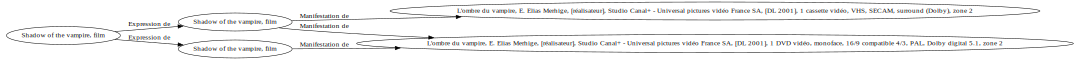

In [42]:
graphe_oeuvre = oeuvreid2graph("UMLRM0129", "15,15")
graphe_oeuvre

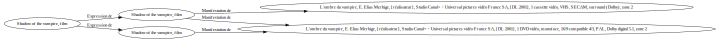

In [43]:
graphe_oeuvre = oeuvreid2graph("UMLRM0129")
graphe_oeuvre

### Fonctions de génération d'un graphe à partir d'une manifestation

In [44]:

def generate_graph_from_manif(manif):
    # A partir d'une manifestation, renvoie un graphe GraphViz
    dot = graphviz.Digraph(manif.id, comment=f'Notice {manif.id}')  
    # Add nodes and edges to the graph object using its node() and edge() or edges() methods:
    dot.node(manif.id, manif.label)
    liste_edges = []
    for expr in manif.toExpressions:
        if expr:
            dot.node(expr, dict_entities[expr].label)
            dot.edge(manif.id, expr, label="manif de")
        for oeuvre in dict_entities[expr].toOeuvres:
            if oeuvre:
                dot.node(oeuvre, dict_entities[oeuvre].label)
                dot.edge(expr, oeuvre, label="expression de")
    return dot
    # dot.edges(liste_edges)
    
def manifid2graph(recordid):
    return generate_graph_from_manif(dict_entities[recordid])

[Liste des notices de manifestations ci-dessus](#Liste-des-manifs-et-liens-aux-expressions)

In [45]:
# Fonction désactivée temporairement
# pour facilités de développement -- mais elle fonctionne

# manifid = input("Numéro de notice de manifestation (exemple : UMLRM0077, avec 2 expressions liées) : ")
manifid = ""

In [46]:
if manifid == "":
    manifid = "UMLRM0077"
graphe_manif = manifid2graph(manifid)

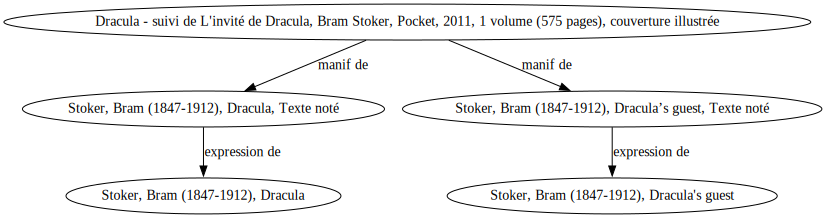

In [47]:
graphe_manif

### Générer un graphe complet

In [48]:
def generate_global_graph(dict_entities, list_links, size):
    # A partir d'une manifestation, renvoie un graphe GraphViz
    dot = graphviz.Digraph("Graphe global", comment=f'Graphe global', format="png")
    colors = {"i": "white", "m": "#C9E0FF", "e": "#BCC9FF", "o": "#BBAAFF",
              "p": "#FF969F", "c": "#FFD1D9"}
    for t in "glntz": 
        colors[t] = "white"
    """for c in colors:
        colors[c] = "red" """
    dot.attr(rankdir='LR')
    dot.attr(size=size)
    # Ajout de tous les noeuds pour les oeuvres
    liste_edges = []
    list_nodes_in_links = set()
    for paire in list_links:
        for l in paire:
            list_nodes_in_links.add(l)
    for e in dict_entities:
        if e in list_nodes_in_links:
            dot.node(e, f"{dict_entities[e].label} [{dict_entities[e].type}]", 
                     color=colors[dict_entities[e].type], style="filled",
                     fillcolor=colors[dict_entities[e].type])
    for e in dict_entities:
        if dict_entities[e].type == "o":
            for resp in dict_entities[e].respIds:
                if resp not in list_nodes_in_links:
                    list_nodes_in_links.add(resp)
                    dot.node(e, f"{dict_entities[resp].label} [{dict_entities[resp].type}]", 
                     color=colors[dict_entities[resp].type], style="filled",
                     fillcolor=colors[dict_entities[resp].type])
                dot.edge(resp, e, label="Auteur")
            for i in dict_entities[e].subjects:
                if i not in list_nodes_in_links:
                    list_nodes_in_links.add(i)
                    dot.node(e, f"{dict_entities[i].label} [{dict_entities[i].type}]", 
                     color=colors[dict_entities[i].type], style="filled",
                     fillcolor=colors[dict_entities[i].type])
                dot.edge(i, e, label="Sujet")
            for gf in dict_entities[e].genreforme:
                if gf not in list_nodes_in_links:
                    list_nodes_in_links.add(gf)
                    dot.node(e, f"{dict_entities[gf].label} [{dict_entities[gf].type}]", 
                     color=colors[dict_entities[gf].type], style="filled",
                     fillcolor=colors[dict_entities[gf].type])
                dot.edge(gf, e, label="genre")
        if dict_entities[e].type == "e":
            for o in dict_entities[e].toOeuvres:
                dot.edge(e, o, label="Expression de")
        elif dict_entities[e].type == "m":
            for expr in dict_entities[e].toExpressions:
                dot.edge(e, expr, label="Manifestation de")
        elif dict_entities[e].type == "i":
            for m in dict_entities[e].toManifs:
                dot.edge(e, m, label="Item de")
    return dot
    # dot.edges(liste_edges)


In [49]:
global_graph = generate_global_graph(dict_entities, liste_liens, "100")
global_graph.render("Graphe global")

'Graphe global.png'

# Coquilles rencontrées

https://semestriel.framapad.org/p/bugs_unimarclrm

In [50]:
with open("stats_zones.txt", "w", encoding="utf-8") as file:
    for entity in dict_entities:
        for zone in dict_entities[entity].stats_zones:
            line = [entity, dict_entities[entity].type, zone, str(dict_entities[entity].stats_zones[zone])]
            file.write("\t".join(line) + "\n")

Expressions sans oeuvre

In [51]:
for expr in expressions:
    if len(expr.toOeuvres) == 0:
        print(expr.id)#

In [52]:
# Longueur des guides.

for el in dict_entities:
    guide = sru.record2fieldvalue(dict_entities[el].xml, "000")
    print(f"{dict_entities[el].type}¤{el}¤{guide}")

i¤UMLRM1000¤00329na a 220012110 4500
i¤UMLRM1001¤00302na a 220010910 4500
i¤UMLRM1002¤00328na a 220012110 4500
i¤UMLRM1003¤00330na a 220012110 4500
i¤UMLRM1004¤00328na a 220012110 4500
i¤UMLRM1005¤00328na a 220012110 4500
i¤UMLRM1006¤00328na a 220012110 4500
i¤UMLRM1007¤00329na a 220012110 4500
i¤UMLRM1008¤00328na a 220012110 4500
i¤UMLRM1009¤00329na a 220012110 4500
i¤UMLRM1010¤00329na a 220012110 4500
i¤UMLRM1011¤00329na a 220012110 4500
i¤UMLRM1012¤00329na a 220012110 4500
i¤UMLRM1013¤00328na a 220012110 4500
i¤UMLRM1014¤00328na a 220012110 4500
i¤UMLRM1015¤00329na a 220012110 4500
i¤UMLRM1016¤00329na a 220012110 4500
i¤UMLRM1017¤00330na a 220012110 4500
i¤UMLRM1018¤00328na a 220012110 4500
i¤UMLRM1019¤00330na a 220012110 4500
i¤UMLRM1020¤00328na a 220012110 4500
i¤UMLRM1021¤00328na a 220012110 4500
i¤UMLRM1022¤00329na a 220012110 4500
i¤UMLRM1023¤00328na a 220012110 4500
i¤UMLRM1024¤00329na a 220012110 4500
i¤UMLRM1025¤00328na a 220012110 4500
i¤UMLRM1026¤00330na a 220012110 4500
i

c¤FRBNF119453097¤01466cx  b2200349   4500
g¤FRBNF133183243¤02646cx  l2200517   4500
p¤FRBNF133438103¤00619cx  a2200205   4500
p¤FRBNF165084538¤00627nx  a2200193   4500
c¤FRBNF138818369¤00707cx  b2200193   4500
p¤FRBNF139382992¤00612cx  a2200193   4500
g¤FRBNF162422739¤03165cx  l2200637   4500
g¤FRBNF11980577X¤01625cx  l2200361   4500
g¤FRBNF119805399¤01442cx  l2200277   4500
g¤FRBNF119497987¤01265cx  l2200265   4500
p¤FRBNF14623074X¤00734cx  a2200205   4500
p¤FRBNF140481044¤00647cx  a2200217   4500
p¤FRBNF120567500¤00690cx  a2200229   4500
p¤FRBNF150729036¤00740cx  a2200229   4500
g¤FRBNF133189029¤04106cx  l2200793   4500
g¤FRBNF119458219¤02207cx  l2200433   4500
g¤FRBNF165553836¤01506cx  l2200289   4500
g¤FRBNF178630115¤01400cx  l2200277   4500
p¤FRBNF121110515¤00596cx  a2200193   4500
p¤FRBNF155399852¤00777nx  a2200229   4500
p¤FRBNF141792728¤00699cx  a2200193   4500
p¤FRBNF137423860¤00812cx  a2200253   4500
p¤FRBNF141209894¤00787cx  a2200241   4500
p¤FRBNF14169469X¤00718cx  a2200229

In [53]:
for rec in dict_entities:
    for resp in dict_entities[rec].respIds:
        if resp not in dict_entities:
            print(rec, dict_entities[rec].type, resp)

UMLRM0024 m FRBNF11447253
UMLRM0027 m FRBNF12938552
UMLRM0030 m FRBNF12111051
UMLRM0057 m FRBNF12363015
UMLRM0077 m FRBNF11889738
UMLRM0110 m FRBNF11447253
UMLRM0122 m 
UMLRM0128 m 
UMLRM0128 m FRBNF12679015
UMLRM0128 m FRBNF16259396
UMLRM0131 m FRBNF13979881
UMLRM0131 m FRBNF14033208
UMLRM0137 m FRBNF14627980
UMLRM0137 m FRBNF17068333
UMLRM0137 m FRBNF14010888
UMLRM0137 m FRBNF14117683
UMLRM0158 m FRBNF13890463
UMLRM0158 m FRBNF13890460
UMLRM0168 m FRBNF14010888
UMLRM0171 m FRBNF13558618
UMLRM0176 m 
UMLRM0179 m FRBNF14623074
UMLRM0182 m FRBNF13890456
UMLRM0185 m FRBNF13979881
UMLRM0185 m FRBNF14033208
UMLRM0185 m FRBNF13881836
UMLRM0188 m FRBNF13889050
UMLRM0190 m 
UMLRM0199 m FRBNF12169702
UMLRM0002 e FRBNF14122771
UMLRM0020 e FRBNF12626285
UMLRM0032 e FRBNF12626285
UMLRM0035 e FRBNF13343810
UMLRM0038 e FRBNF11902797
UMLRM0041 e FRBNF15547545
UMLRM0047 e FRBNF11902797
UMLRM0050 e FRBNF11902797
UMLRM0053 e FRBNF12052485
UMLRM0056 e FRBNF12126118
UMLRM0056 e FRBNF12630239
UMLRM0059 e 

In [54]:
for el in autres_entites:
    print(el.id)

FRBNF138761797
FRBNF114472535
FRBNF138766730
FRBNF119759959
FRBNF119810108
FRBNF119628415
FRBNF123108018
FRBNF119365081
FRBNF123107172
FRBNF140108885
FRBNF138904633
FRBNF138890500
FRBNF155519020
FRBNF155137309
FRBNF139397275
FRBNF144661310
FRBNF119459723
FRBNF146763424
FRBNF146911079
FRBNF119770069
FRBNF16166678X
FRBNF119758323
FRBNF138904569
FRBNF140332082
FRBNF150624252
FRBNF165376229
FRBNF141734792
FRBNF139058638
FRBNF161666391
FRBNF119314076
FRBNF13545625X
FRBNF119453097
FRBNF133183243
FRBNF133438103
FRBNF165084538
FRBNF138818369
FRBNF139382992
FRBNF162422739
FRBNF11980577X
FRBNF119805399
FRBNF119497987
FRBNF14623074X
FRBNF140481044
FRBNF120567500
FRBNF150729036
FRBNF133189029
FRBNF119458219
FRBNF165553836
FRBNF178630115
FRBNF121110515
FRBNF155399852
FRBNF141792728
FRBNF137423860
FRBNF141209894
FRBNF14169469X
FRBNF15547545X
FRBNF138904601
FRBNF119124422
FRBNF148943855
FRBNF142236392
FRBNF139382946
FRBNF119750860
FRBNF135586182
FRBNF141713403
FRBNF140012577
FRBNF126262854
FRBNF13979

# Pseudo-moteur de recherche 

L'objectif est de proposer une boîte de saisie pour chercher un ou plusieurs mots-clés, et évaluer les résultats d'affichage possible


In [55]:
def clean_str(string):
    string = unidecode(string.lower())
    punct = "!:,;.?/%$\"'"
    for char in punct:
        string = string.replace("char", " ")
    string = " ".join([el for el in string.split(" ") if el])
    return string

def search(keywords, dict_entities, index="all"):
    keywords = clean_str(keywords).split(" ")
    results_entities = {}
    for o in oeuvres:
        if index == "all":
            for k in keywords:
                if k in o.global_index:
                    results_entities[o.id] = o
    return results_entities

def short_display(results_entities):
    i = 1
    for e in results_entities:
        print("")
        print(f"{str(i)}.",  results_entities[e].label)
        print("")
        if i < len(results_entities) :
            print("-"*20)
        i += 1
    
def full_display(results_entities, kw_search):
    i = 1
    for e in results_entities:
        print("")
        print(f"{str(i)}.",  results_entities[e].detailed)
        print("")
        if i < len(results_entities) :
            print("-"*20)
        i += 1
    
    
def display_results(results_entities, kw_search):
    
    print("\nRappel de la recherche : ", kw_search)
    print("Nombre de résultats :", len(results_entities))
    short_display(results_entities)
    print("\n", "*"*20, "\n*    Résultats détaillés   *\n", "*"*20, "\n")
    full_display(results_entities, kw_search)

### Formulaire de recherche simple

In [56]:
kw_search = input("Chercher dans la base : ")
results = search(kw_search, dict_entities, "all")
display_results(results, kw_search)

Chercher dans la base : note

Rappel de la recherche :  note
Nombre de résultats : 4

1. Humphries, Tudor (1953-….), Dracula

--------------------

2. "Dracula" : l'oeuvre de Bram Stoker et le film de Francis F. Coppola

--------------------

3. Stoker, Dacre - Holt, Ian (1964-….), Dracula, the un-dead

--------------------

4. Stoker, Bram (1847-1912), Choix, Manuscrits


 ******************** 
*    Résultats détaillés   *
 ******************** 


1. Humphries, Tudor (1953-….)
Date de première publication : 1997

--------------------

2. "Dracula" : l'oeuvre de Bram Stoker et le film de Francis F. Coppola
Date de première publication : 2005

--------------------

3. Stoker, Dacre¤Holt, Ian (1964-….)
Date de première publication : 2009

--------------------

4. Stoker, Bram (1847-1912). Choix
Date de première publication : 2008



### Recherche avec pages HTML

La recherche génére une page de résultats dans [results/short_results.html](results/short_results.html), laquelle contient des liens vers des notices détaillées

On peut ensuite supprimer toutes les pages générées en utilisant la fonction `delete_html_results()`

In [57]:
from generate_results import display_html_results, delete_html_results

In [61]:
kw_search = input("Chercher dans la base : ")
results = search(kw_search, dict_entities, "all")
display_html_results(results, kw_search)

Chercher dans la base : dracula


#### Supprimer les pages de résultats

In [62]:
delete_html_results()

# Corrections à faire

Notice d'oeuvre UMLRM0163 : 2e zone 640 erronée :
```640 6  $0 Date de première sortie en salle $a US $d New ```

Notice de manif : lien 716$3 FRBNF13876673 --> FRBNF138766730 (notice de marque)

Coquilles sur les identifiants en général